In [4]:
#Importing the libraries required
import pandas as pd
#import numpy as np

In [5]:
train=pd.read_csv("train.csv",na_values={"Item_Visibility":[0]})

In [6]:
test=pd.read_csv("test.csv",na_values={"Item_Visibility":[0]})

In [7]:
train['source']='train'

In [8]:
test['source']='test'

In [9]:
data=pd.concat([train,test],ignore_index=True)


C:\Users\RUPESH\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [10]:
sort=True

In [11]:
#the one thing we have to focus is item_outlet_Sales


discpt=data.describe()

In [12]:
#Lets find out how many  zero'es values are

nan_descript=data.apply(lambda x: sum(x.isnull()))

In [13]:
#Now lets find out the unique values in each of the catogorical columns

uniq=data.apply(lambda x: len(x.unique()))

In [14]:
#let do grouping in each catogorical columns

col=["Item_Fat_Content","Item_Type","Outlet_Location_Type","Outlet_Size"]

for i in col:
    print("The frequency distribution of each catogorical columns is--" + i+"\n")
    print(data[i].value_counts())   

The frequency distribution of each catogorical columns is--Item_Fat_Content

Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64
The frequency distribution of each catogorical columns is--Item_Type

Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64
The frequency distribution of each catogorical columns is--Outlet_Location_Type

Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64
The frequency distribution of each catogorical columns is--

In [15]:
#Replacing the minimum nan values in the Item_Weight with its mean value

data.fillna({"Item_Weight":data["Item_Weight"].mean()},inplace=True)

In [16]:
#checking the current status of  nan values in the dataframe
nan_descript=data.apply(lambda x: sum(x.isnull()))

In [17]:
#Now we have 0 nan valuesin Item_Weight


data["Outlet_Size"].fillna(method="ffill",inplace=True)


nan_descript=data.apply(lambda x: sum(x.isnull()))

In [18]:
#Now working on the item_visibility


visibilty_avg=data.pivot_table(values="Item_Visibility",index="Item_Identifier")


itm_visi=data.groupby('Item_Type')

data_frames=[]
for item,item_df in itm_visi:
    data_frames.append(itm_visi.get_group(item))
for i in data_frames:
    i["Item_Visibility"].fillna(value=i["Item_Visibility"].mean(),inplace=True)
    i["Item_Outlet_Sales"].fillna(value=i["Item_Outlet_Sales"].mean(),inplace=True)

new_data=pd.concat(data_frames)

nan_descript=new_data.apply(lambda x: sum(x.isnull()))

C:\Users\RUPESH\Anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [19]:
#Now we have successfully cleaned our complete dataset.
new_data["Item_Fat_Content"].replace({'LF':'Low Fat','reg':'Regular','low fat':'Low Fat'},inplace=True)

new_data["Item_Fat_Content"].value_counts()

Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64

In [20]:
#Implementing one-hot-Coding method for getting the categorical variables
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data=new_data
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type','Outlet_Type']
le = LabelEncoder()
for i in var_mod:
    data[i] = le.fit_transform(data[i])
#One Hot Coding:
data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type'])

In [21]:
#Exporting the datas

train = data.loc[data['source']=="train"]

test = data.loc[data['source']=="test"]

In [22]:
#Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
#here we are droping the "Item_Outlet_Sales because this only we want to be predicted from the model that we are going to built
train.drop(['source'],axis=1,inplace=True)

C:\Users\RUPESH\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [23]:
#Export files as modified versions:
train.to_csv("train_modified.csv",index=False)
test.to_csv("test_modified.csv",index=False)

In [24]:
#Let's start building the baseline model as  it is non -predicting model and also commenly known as informed guess

#Mean based:
mean_sales = train['Item_Outlet_Sales'].mean()


In [25]:
#Define a dataframe with IDs for submission:
base1 = test[['Item_Identifier','Outlet_Identifier']]
base1['Item_Outlet_Sales'] = mean_sales

C:\Users\RUPESH\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
#Export submission file
base1.to_csv("alg0.csv",index=False)

In [27]:
#Define target and ID columns:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']

In [28]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [29]:
def modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])

    #Perform cross-validation:
    cv_score = cross_val_score(alg, dtrain[predictors], dtrain[target], cv=20, scoring='neg_mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print ("\nModel Report")
    print ("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    #Predict on testing data:
    dtest[target] = alg.predict(dtest[predictors])
    
    #Export submission file:
    IDcol.append(target)
    submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    submission.to_csv(filename, index=False)

In [30]:
#Liner Regression model
print("Creating the models and processing")
from sklearn.linear_model import LinearRegression, Ridge
predictors = [x for x in train.columns if x not in [target]+IDcol]
# print predictors
alg1 = LinearRegression(normalize=True)
modelfit(alg1, train, test, predictors, target, IDcol, 'alg1.csv')
coef1 = pd.Series(alg1.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')


Creating the models and processing

Model Report
RMSE : 1128
CV Score : Mean - 4.838e+14 | Std - 1.146e+15 | Min - 1005 | Max - 4.769e+15


C:\Users\RUPESH\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Model Report
RMSE : 1059
CV Score : Mean - 1090 | Std - 74.92 | Min - 932.5 | Max - 1266


C:\Users\RUPESH\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Model has been successfully created and trained. The predicted result is in alg3.csv


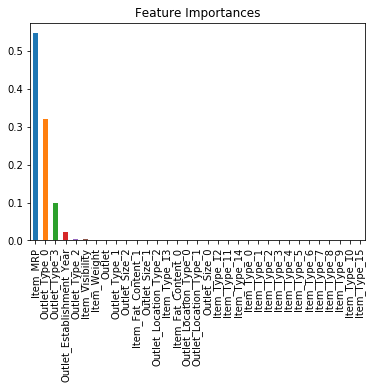

In [32]:
# Decision Tree Model

from sklearn.tree import DecisionTreeRegressor
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg3 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
modelfit(alg3, train, test, predictors, target, IDcol, 'alg3.csv')
coef3 = pd.Series(alg3.feature_importances_, predictors).sort_values(ascending=False)
coef3.plot(kind='bar', title='Feature Importances')

print("Model has been successfully created and trained. The predicted result is in alg3.csv")


Model Report
RMSE : 1073
CV Score : Mean - 1081 | Std - 75.48 | Min - 938.4 | Max - 1262


C:\Users\RUPESH\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Model has been successfully created and trained. The predicted result is in alg5.csv

Model Report
RMSE : 1068
CV Score : Mean - 1080 | Std - 75.87 | Min - 934.7 | Max - 1262


C:\Users\RUPESH\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Model has been successfully created and trained. The predicted result is in alg6.csv


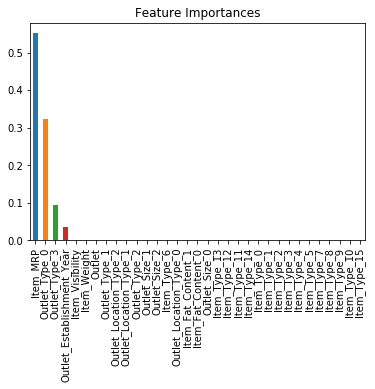

In [38]:
#Random Forest Model

from sklearn.ensemble import RandomForestRegressor

predictors = [x for x in train.columns if x not in [target]+IDcol]
alg5 = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4)
modelfit(alg5, train, test, predictors, target, IDcol, 'alg5.csv')
coef5 = pd.Series(alg5.feature_importances_, predictors).sort_values(ascending=False)
coef5.plot(kind='bar', title='Feature Importances')

print("Model has been successfully created and trained. The predicted result is in alg5.csv")

predictors = [x for x in train.columns if x not in [target]+IDcol]
alg6 = RandomForestRegressor(n_estimators=400,max_depth=6, min_samples_leaf=100,n_jobs=4)
modelfit(alg6, train, test, predictors, target, IDcol, 'alg6.csv')
coef6 = pd.Series(alg6.feature_importances_, predictors).sort_values(ascending=False)
coef6.plot(kind='bar', title='Feature Importances')

print("Model has been successfully created and trained. The predicted result is in alg6.csv")
